# LiveEO Data Science Challenge - Thibault Latrace

Import of the libraries and the tools that will be used during the whole study

In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scikitplot as skplt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import cross_val_score

Exploration of the labeled dataset metadata :

In [27]:
dataset = rasterio.open('rasterize_on_sentinel_2_labelled_17SLD.tif')

print(dataset.meta)

# Outputs :

# crs : EPSG 32617 --> referencing the UTM zone 17N
# shape : (10980, 10980)
# dtype : uint32
# number of bands : 2 --> only the first one will be used

{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': 4294967295.0, 'width': 10980, 'height': 10980, 'count': 2, 'crs': CRS.from_epsg(32617), 'transform': Affine(10.0, 0.0, 300000.0,
       0.0, -10.0, 4400040.0)}


Visualization of the dataset :

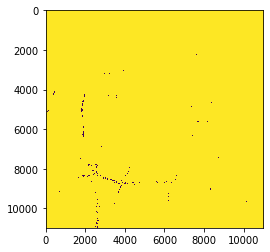

In [28]:
labeled_band = dataset.read(1)

plt.imshow(labeled_band)

# It seems like a satellite image of islands

# TODO : translate the coordinates of the TIF file into Mercator coordinates to visualize it on Google

Transformation of the labelled band into a DataFrame in order to ease the manipulation:

In [29]:
ravelled_label_band = labeled_band.ravel()

label_band_df = pd.DataFrame(ravelled_label_band)

label_band_df = label_band_df.replace(4294967295, np.nan)

previous_label_band_size = label_band_df.shape

Drop of the label nodata values :

In [30]:
reduced_label_band_df = label_band_df.dropna().rename(columns = {0: 'label'})

reduced_label_band_df['label'] = reduced_label_band_df['label'].astype(int)

new_label_band_size = reduced_label_band_df.shape

print(previous_label_band_size[0]/new_label_band_size[0])

# Output : 369.37415553737696

# We just divided by almost 400 the size of our dataset !!!
# It will be a lot more convenient to work with this size-reduced data for the machine learning process

369.37415553737696


Concatenation of the labeled layer and the first band of the dataset, by projecting the band where the labeled data is not null : 

In [31]:
bands_folder_path = 'S2_17SLD_2019-09-15_masked_warped'

band_paths = [os.path.join(bands_folder_path, my_file)
              for my_file in os.listdir(bands_folder_path)
              if os.path.isfile(os.path.join(bands_folder_path, my_file))]

final_dataset_df = reduced_label_band_df
for band_number in range(len(band_paths)):
    with rasterio.open(band_paths[band_number]) as band_dataset:
        band = band_dataset.read(1)
        ravelled_band = band.ravel()
        band_df = pd.DataFrame(ravelled_band).rename(columns = {0: '{}'.format(band_paths[band_number].split('\\')[1].split('_')[2])})
        
        final_dataset_df = pd.concat([final_dataset_df, band_df.reindex(final_dataset_df.index)], axis = 1)
        band_dataset.close()
print(final_dataset_df)

# TODO : look for the signification of each band

           label  AOT
350913         3   69
354514         0   70
354515         0   70
354516         0   70
354517         0   70
...          ...  ...
120332403      4   70
120409747      3   70
120420734      3   70
120464649      3   70
120519538      3   70

[326391 rows x 2 columns]
           label  AOT   B01
350913         3   69   360
354514         0   70  2347
354515         0   70  2347
354516         0   70  3878
354517         0   70  3878
...          ...  ...   ...
120332403      4   70   264
120409747      3   70   589
120420734      3   70   760
120464649      3   70   768
120519538      3   70   442

[326391 rows x 3 columns]
           label  AOT   B01   B02
350913         3   69   360   391
354514         0   70  2347  2302
354515         0   70  2347  4328
354516         0   70  3878  4316
354517         0   70  3878  4460
...          ...  ...   ...   ...
120332403      4   70   264   236
120409747      3   70   589   322
120420734      3   70   760   713
120464

           label  AOT   B01   B02   B03   B04   B05   B06   B07   B08   B09  \
350913         3   69   360   391   640   735  1274  1954  2300  2374  2620   
354514         0   70  2347  2302  2674  2778  3944  4185  3975  2784  2979   
354515         0   70  2347  4328  4272  4220  3944  4185  3975  4220  2979   
354516         0   70  3878  4316  4564  4728  5445  5242  5489  4500  3836   
354517         0   70  3878  4460  4400  4792  5445  5242  5489  4600  3836   
...          ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
120332403      4   70   264   236   466   263   702  2844  3513  3340  3834   
120409747      3   70   589   322   462   473  1077  1570  1836  1596  1835   
120420734      3   70   760   713   939   991  1288  1654  1832  1780  1812   
120464649      3   70   768   517   576   686  1084  1603  1857  2064  2022   
120519538      3   70   442   329   530   438   949  1697  1891  1992  1924   

            B11   B12   B8A  
350913     2853  1803

Reindexing and add of a label mapping in order to improve lisibility of the dataset :

In [32]:
#insertion of the label_meaning column
final_dataset_df.insert(1, 'label_meaning', final_dataset_df['label'])
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
final_dataset_df['label_meaning'] = final_dataset_df['label_meaning'].replace(label_mapping)

final_dataset_df = final_dataset_df.reset_index().rename(columns = {'index': 'previous_index'})
final_dataset_df.head()

,previous_index,label,label_meaning,AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP
0,350913,3,single tree,69,360,391,640,735,1274,1954,2300,2374,2620,2853,1803,2566,4,2728
1,354514,0,urban,70,2347,2302,2674,2778,3944,4185,3975,2784,2979,3758,2708,3884,9,2241
2,354515,0,urban,70,2347,4328,4272,4220,3944,4185,3975,4220,2979,3758,2708,3884,9,2241
3,354516,0,urban,70,3878,4316,4564,4728,5445,5242,5489,4500,3836,4589,2917,5310,9,2518
4,354517,0,urban,70,3878,4460,4400,4792,5445,5242,5489,4600,3836,4589,2917,5310,9,2518


Storing of the final dataset into a csv :

In [33]:
final_dataset_df.to_csv('final_dataset.csv',  index = False)

CHECKPOINT : To this point, we don't need to execute the code above anymore : the dataset is definitly stored in the file 'final_dataset.csv'.

We split the dataset into train and test data : 80% for the training data and 20% for the testing one.

Furthermore, as long as we want to predict a class (survived or not), we will use a Classifier model. It will be here a RandomForestClassifier.

In [54]:
final_dataset_df = pd.read_csv('final_dataset.csv')
final_dataset_df = final_dataset_df.drop(columns = 'label_meaning')

# split of the dataset
prediction_target = final_dataset_df['label']
X = final_dataset_df.drop(columns = ['label', 'previous_index'])
train_data, test_data, train_prediction_target, test_prediction_target = train_test_split(X, prediction_target, train_size = 0.8, random_state = 1)

# classifier training
model = RandomForestClassifier(random_state = 1)
model.fit(train_data, train_prediction_target)
predictions = model.predict(test_data)

# evaluation of the classifier
confusion_mtrx_1 = confusion_matrix(test_prediction_target, predictions)
class_report_1 = classification_report(test_prediction_target, predictions, zero_division = True)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3795
           1       0.93      0.78      0.85      1390
           2       0.99      1.00      0.99     30760
           3       1.00      0.00      0.00        21
           4       0.99      1.00      0.99     18896
           5       0.98      0.93      0.95      1496
           6       1.00      1.00      1.00      8921

    accuracy                           0.99     65279
   macro avg       0.98      0.81      0.83     65279
weighted avg       0.99      0.99      0.99     65279



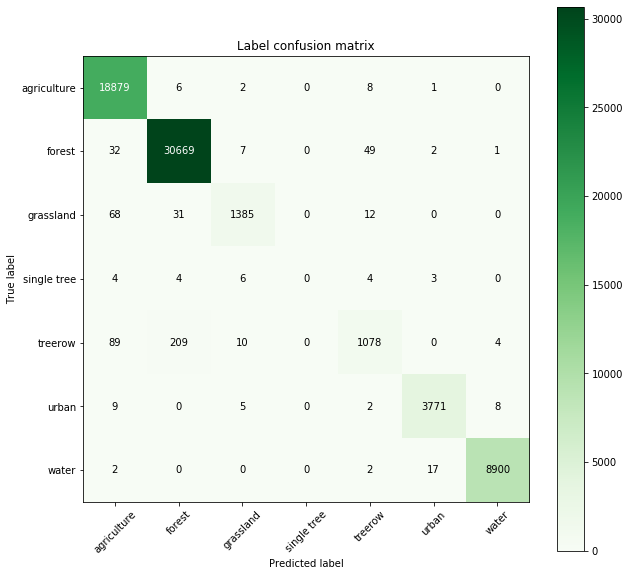

In [56]:
# smooth plot of the confusion matrix
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
skplt.metrics.plot_confusion_matrix(
    test_prediction_target.replace(label_mapping), 
    pd.DataFrame(predictions).replace(label_mapping),
    figsize = (10, 10),
    title = 'Label confusion matrix',
    x_tick_rotation = 45,
    cmap = 'Greens')

print(class_report_1)

Improvement of the model :

We squash the 3 RGB layers into a unique grayscale layer :

In [ ]:
final_dataset_df = pd.read_csv('final_dataset.csv')
final_dataset_df = final_dataset_df.drop(columns = 'label_meaning')

# creation of the grayscale column
# the weights are respectively for : red, green, blue
# B02 = red, B03 = green, B04 = blue
rgb_weights = [0.2989, 0.5870, 0.1140]
rgb_df = pd.concat([final_dataset_df['B04'], final_dataset_df['B03'], final_dataset_df['B02']], axis = 1)
grayscale_df = rgb_df.dot(rgb_weights)
grayscale_df = grayscale_df.map(np.round).astype(int)
final_dataset_df.insert(4, 'grayscale', grayscale_df)

# split of the dataset
prediction_target = final_dataset_df['label']
X = final_dataset_df.drop(columns = ['label', 'previous_index', 'B02', 'B03', 'B04'])
train_data, test_data, train_prediction_target, test_prediction_target = train_test_split(X, prediction_target, train_size = 0.8, random_state = 1)

# classifier training
model = RandomForestClassifier(random_state = 1)
model.fit(train_data, train_prediction_target)
predictions = model.predict(test_data)

# evaluation of the classifier :
confusion_mtrx_2 = confusion_matrix(test_prediction_target, predictions)
class_report_2 = classification_report(test_prediction_target, predictions, zero_division = True)

        AOT   B01  grayscale   B05   B06   B07   B08   B09   B11   B12   B8A  \
0        69   360        640  1274  1954  2300  2374  2620  2853  1803  2566   
1        70  2347       2662  3944  4185  3975  2784  2979  3758  2708  3884   
2        70  2347       4262  3944  4185  3975  4220  2979  3758  2708  3884   
3        70  3878       4584  5445  5242  5489  4500  3836  4589  2917  5310   
4        70  3878       4524  5445  5242  5489  4600  3836  4589  2917  5310   
...     ...   ...        ...   ...   ...   ...   ...   ...   ...   ...   ...   
326386   70   264        379   702  2844  3513  3340  3834  1826   835  3809   
326387   70   589        449  1077  1570  1836  1596  1835  1815  1329  1947   
326388   70   760        929  1288  1654  1832  1780  1812  1817  1621  1801   
326389   70   768        602  1084  1603  1857  2064  2022  2193  1752  1983   
326390   70   442        480   949  1697  1891  1992  1924  1891  1408  2117   

        SCL   WVP  
0         4  2728  

In [ ]:
# smooth plot of the confusion matrix
label_mapping = {0: 'urban', 1: 'treerow', 2: 'forest', 3: 'single tree', 4: 'agriculture', 5: 'grassland', 6: 'water'}
skplt.metrics.plot_confusion_matrix(
    test_prediction_target.replace(label_mapping), 
    pd.DataFrame(predictions).replace(label_mapping),
    figsize = (10, 10),
    title = 'Label confusion matrix',
    x_tick_rotation = 45,
    cmap = 'Greens')

print(class_report_2)

In [1]:
# TODO : use seaborn module to do display the confusion matrix

Test d'utilisation de mlflow

In [59]:
import mlflow
from mlflow import log_param, log_metric
from random import random, randint

In [66]:
mlflow.start_run()

log_param("param1", randint(0, 100))

log_metric("foo", random())
log_metric("foo", random() + 1)
log_metric("foo", random() + 2)

if not os.path.exists("outputs"):
    os.makedirs("outputs")
with open("outputs/test.txt", "w") as f:
    f.write("hello world!")

log_artifacts("outputs")

mlflow.end_run()